## mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [2]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [18]:
cd 'Your code directory'

/content/drive/MyDrive/Medical Gan/Siavash/Github


In [19]:
from __future__ import division
from IPython.display import clear_output
from Functions import PlotingResaults
from Functions import EvaluateMain 
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import ConvLSTM2D
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import Reshape
from keras.layers import UpSampling2D
from keras.models import Model
from skimage import data
from scipy import ndimage
from skimage import filters
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import Functions 
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import pickle


## Prepare the data

In [5]:
input_lung = np.load('.../input_lung.npy')
out_gan = np.load('.../output_lung_gen.npy')
differentiated_lung = input_lung - out_gan

In [6]:
#### creating pseudo mask
sum = []
counter1=0
x_train_hi = np.zeros((0,128,128,1))
x_train_lo = np.zeros((0,128,128,1))
m_train_hi = np.zeros((0,128,128,1))
m_train_lo = np.zeros((0,128,128,1))

for i in tqdm(range(differentiated_lung.shape[0])):
    sum.append(np.sum(differentiated_lung[i,:,:,:]))
    if(sum[-1]>95):
        x_train_hi = np.append(x_train_hi,input_lung[i:i+1,:,:,:],axis=0)
        m_train_hi = np.append(m_train_hi,differentiated_lung[i:i+1,:,:,:],axis=0)
        counter1+=1

sum = []
counter=0
for i in tqdm(range(differentiated_lung.shape[0])):
    sum.append(np.sum(differentiated_lung[i,:,:,:]))
    if(65<sum[-1]<80):
        x_train_lo = np.append(x_train_lo,input_lung[i:i+1,:,:,:],axis=0)
        m_train_lo = np.append(m_train_lo,differentiated_lung[i:i+1,:,:,:],axis=0)
        counter+=1


100%|██████████| 21248/21248 [01:39<00:00, 213.99it/s]


In [7]:
print(x_train_lo.shape,x_train_hi.shape)
y_train_lo = np.zeros((x_train_lo.shape[0],1))
y_train_hi = np.ones((x_train_hi.shape[0],1))

(1873, 128, 128, 1) (1792, 128, 128, 1)


In [8]:
## to be balanced
x_train = np.append(x_train_hi,x_train_lo[:1792],axis=0)
y_train = np.append(y_train_hi,y_train_lo[:1792],axis=0)
m_train = np.append(m_train_hi,m_train_lo[:1792],axis=0)

## Using image data augmentation

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.04),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

## Build the encoder model



In [10]:
def create_encoder(inputs,aug_allow='aug'):
    N = 128
    if aug_allow == 'aug':
        inputs = data_augmentation(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    

    up61 = layers.GlobalAveragePooling2D()(drop4_3)
    return up61, drop4_3,conv1,conv2,drop3

input_size = (128,128,1)
inputs = Input(input_size) 
up61,_,_,_,_ = create_encoder(inputs)
my_create_encoder = Model(inputs, up61)
my_create_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   3           ['input_1[0][0]']                
                                1)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   320         ['sequential[0][0]']             
                                32)                                                           

## contrastive loss

In [11]:
projection_units = 128
temperature = 0.05

In [12]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(inputs):
    outputs = layers.Dense(projection_units, activation="relu")(inputs)
    return outputs


## Main network

In [13]:
def batch_data(ntrain=10,ntest=10):
    trainidx1 = random.sample(range(0,int(3584/2)), ntrain)
    trainidx2 = random.sample(range(int(3584/2),3584), ntrain)
    trainidx = np.append(trainidx1,trainidx2)
    XTr = x_train[trainidx,:,:,:]
    MTr = m_train[trainidx,:,:,:]
    YTr = y_train[trainidx,:]
    return XTr,MTr,YTr

In [14]:
# from IPython import display
def plot_loss(C_losss,A_losss):
        plt.figure(figsize=(5,5))
        plt.subplot(311)
    
        plt.plot(C_losss, label='Contrstive loss')
        plt.legend()
                
        plt.subplot(312)
        plt.plot(A_losss, label='AE loss')
        plt.legend()
        plt.show()

def plot_sample(samples):
    for sample in samples:
        plt.figure(figsize=(10,10))
        plt.subplot(131)
        plt.imshow(x_train[sample,:,:,0])
        plt.subplot(132)
        plt.imshow(m_train[sample,:,:,0])
        plt.subplot(133)
        plt.imshow(my_en_de.predict(x_train[sample:sample+1,:,:,:])[0,:,:,0])
        plt.show()


In [15]:
def train_en_con(inputs):
    encoder,_,_,_,_ = create_encoder(inputs,aug_allow='aug')
    encoder_with_projection_head = add_projection_head(encoder)
    return encoder_with_projection_head

In [16]:

def train_unet(inputs, trainable=True):

    N=128
    encoder,drop4_3,conv1,conv2,drop3 = create_encoder(inputs,aug_allow='No')
    
    up6 = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)
    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 64, kernel_size=(2, 2), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal')(merge6)
            
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 32, kernel_size=(2, 2), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(32, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 32))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 32))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 16, kernel_size=(2, 2), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'tanh')(conv8)
    return conv9

input_size = (128,128,1)
inputs = Input(input_size)
en_de = train_unet(inputs)
my_en_de = Model(inputs, en_de)
my_en_de.summary()

encoded = train_en_con(inputs)
my_train_en_con = Model(inputs, encoded)
my_train_en_con.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_12[0][0]']              
                                )                                                           

In [17]:
initial_learning_rate = 0.00005
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

g_opt = keras.optimizers.Adam(learning_rate= initial_learning_rate)
my_en_de.compile(loss='mse', optimizer=g_opt)

learning_rate = 0.0001
my_train_en_con.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=SupervisedContrastiveLoss(temperature),
        metrics='Accuracy')


In [ ]:
def train_for_n(nb_epoch, plt_frq,ntrain):
    C_losss = []
    A_losss = [] 
    for e in (range(nb_epoch)):  
        print(e,end='')
        for _ in range(2):
            XTr,MTr,YTr = batch_data(ntrain=4)
            C_loss,_ = my_train_en_con.train_on_batch(XTr,YTr)
        
        XTr,MTr,YTr = batch_data(ntrain=4)
        A_loss = my_en_de.train_on_batch(XTr,MTr)

        C_losss.append(C_loss)
        A_losss.append(A_loss)

       
        # Updates plots
        if e%plt_frq==plt_frq-1:
            my_train_en_con.save('.../my_train_en_con', save_format='h5')
            my_en_de.save('.../my_en_de', save_format='h5')
            clear_output()
            plot_loss(C_losss,A_losss)
            plot_sample([3350,3260,3272])

In [ ]:
tf.config.run_functions_eagerly(True)

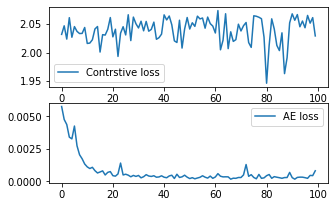

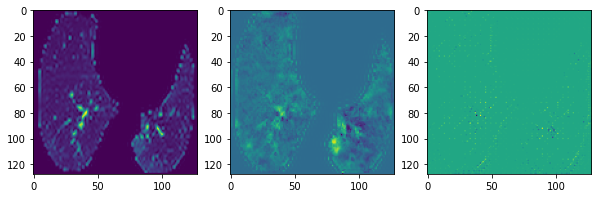

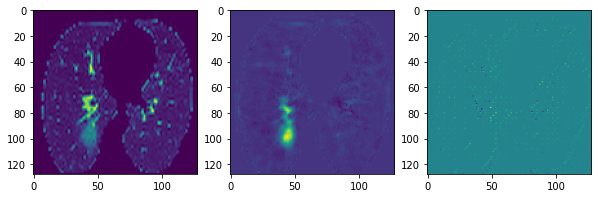

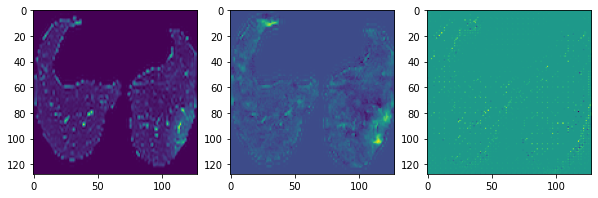

In [ ]:
train_for_n(nb_epoch=100,
            plt_frq=50,
            ntrain=8)

## check the result on CoronaCases dataset

In [23]:
### load the model 
import keras
BCDU_net_D3_model = keras.models.load_model('.../my_en_de')
BCDU_net_D3_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_77 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_76[0][0]']              
                                )                                                           

In [41]:
#### calculate the output of model 
def OutPutModel(my_data):
    my_out = []
    for i in tqdm(range(len(my_data))):
        my_out.append(BCDU_net_D3_model.predict(my_data[i][0,:,:,:]))
    return my_out


def Add_Dim(data):
    ################## add a dim to data
    data_scaled = []
    for j in tqdm(range(len(data))):
            output = np.zeros((1,data[j].shape[0],data[j].shape[1],data[j].shape[2],1))
            output[0,:,:,:,0] = data[j][:,:,:] 
            data_scaled.append(output)
    return data_scaled


def LoadData(DatasetName):

    ############## Load 
    if(DatasetName=='cronacases'):
        with open('.../CT_Images.pickle', 'rb') as f:
            data = pickle.load(f)

        with open('.../Lung_Masks.pickle', 'rb') as f:
            LungMask = pickle.load(f)

        with open('.../Masks.pickle', 'rb') as f:
            mask  = pickle.load(f)

        for i in range(len(mask)):
            mask[i]=np.where(np.array(mask[i])>0.5,1,0) 
            LungMask[i]=np.where(np.array(LungMask[i])>0.0005,1,0)

    if(DatasetName=='cronacases_spacing1'):
        with open('.../CT_Images.pickle', 'rb') as f:
            data = pickle.load(f)

        with open('.../Lung_Masks.pickle', 'rb') as f:
            LungMask = pickle.load(f)

        with open('.../Masks.pickle', 'rb') as f:
            mask  = pickle.load(f)

        for i in range(len(mask)):
            mask[i]=np.where(np.array(mask[i])>0.5,1,0) 
            LungMask[i]=np.where(np.array(LungMask[i])>0.0005,1,0)


    ####################### Add a dim
    Data_scaled = Add_Dim(data)
    
    ########### add a dim to mask
    mask_scaled = Add_Dim(mask)
    
    ### get output of model 
    my_out = OutPutModel(Data_scaled)

    return Data_scaled,my_out, mask_scaled, LungMask

In [43]:
#### upload data  
my_data, my_out, mask_scaled, LungMask = LoadData("cronacases")


####### Calculating the evaluation metrics(Dice score, Specificity, Sensitivity )
dice_list, sensitivity_list, specificity_list, InfectionPercent = EvaluateMain(my_data,my_out,mask_scaled,LungMask,Threshold= 0.2,thresholdMethod='1',
                                                                                      PlotingCase=10,PlotingSlice=15,PostPro=False)

############### ploting resauts

### Dice score  
PlotingResaults(dice_list ,InfectionPercent,ScoreName='Dice score')

##### Sensitivity
PlotingResaults(sensitivity_list,InfectionPercent,ScoreName='Sensitivity')


##### Specificity
PlotingResaults(specificity_list,InfectionPercent,ScoreName='specificity')



  0%|          | 0/10 [00:00<?, ?it/s]/content/drive/My Drive/Medical Gan/Siavash/Github/Functions.py:60: RuntimeWarning: Mean of empty slice.
  return np.array(dice).mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/content/drive/My Drive/Medical Gan/Siavash/Github/Functions.py:45: RuntimeWarning: Mean of empty slice.
  return np.array(sensitivity).mean()
/content/drive/My Drive/Medical Gan/Siavash/Github/Functions.py:52: RuntimeWarning: Mean of empty slice.
  return np.array(specificity).mean()
100%|██████████| 10/10 [00:00<00:00, 91.56it/s]

Dice score Mean: 64.2730799833762 Dice score Std: 16.637583430796095
Sensitivity Mean: 77.73042545215301 Sensitivity Std: 13.519746334210012
specificity Mean: 97.41716758272638 specificity Std: 2.5836241122437675


In [ ]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl